### Data Preprocessing

In [422]:
import os
from pathlib import Path
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import missingno as msno
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [423]:
# import data 
df = pd.read_csv("../../data/raw/triathlon_watch_training_data_final.csv")
# Make sure column names are lower case and eliminate spaces
df.columns = df.columns.str.lower()
# Replace spaces with underscores
df.columns = df.columns.str.replace(r" ", r"_", regex=True)

In [424]:
#Transform the date column into numeric column
df["most_current_software_update"] = pd.to_datetime(df["most_current_software_update"], format="%Y-%m-%d")
df["most_current_software_update"] = df["most_current_software_update"].max() - df["most_current_software_update"]
df["most_current_software_update"] = df["most_current_software_update"].dt.days


### Correction of Data Quality Issues

In the exploratory data anylsis, we saw that there are some inconsisent data in the column 'ctry', which might effect the machine learning performance of our model. In the following this data quality issues will be corrected.

In [425]:
# Show distribution of categorical values of the attribute "ctry" before corrections
df['ctry'].value_counts()

ctry
Australia      200
USA            199
UK             191
India          186
Germany        179
Germayn         19
UnknownLand      4
Name: count, dtype: int64

In [426]:
#Replcacement of all values 'Germanyn' with 'Germany'
df['ctry'] = df['ctry'].replace('Germayn', 'Germany')
#Show the distribution of categorical values of the attribute "ctry" after corrections
df['ctry'].value_counts()

ctry
Australia      200
USA            199
Germany        198
UK             191
India          186
UnknownLand      4
Name: count, dtype: int64

### Missing values handling


<Axes: >

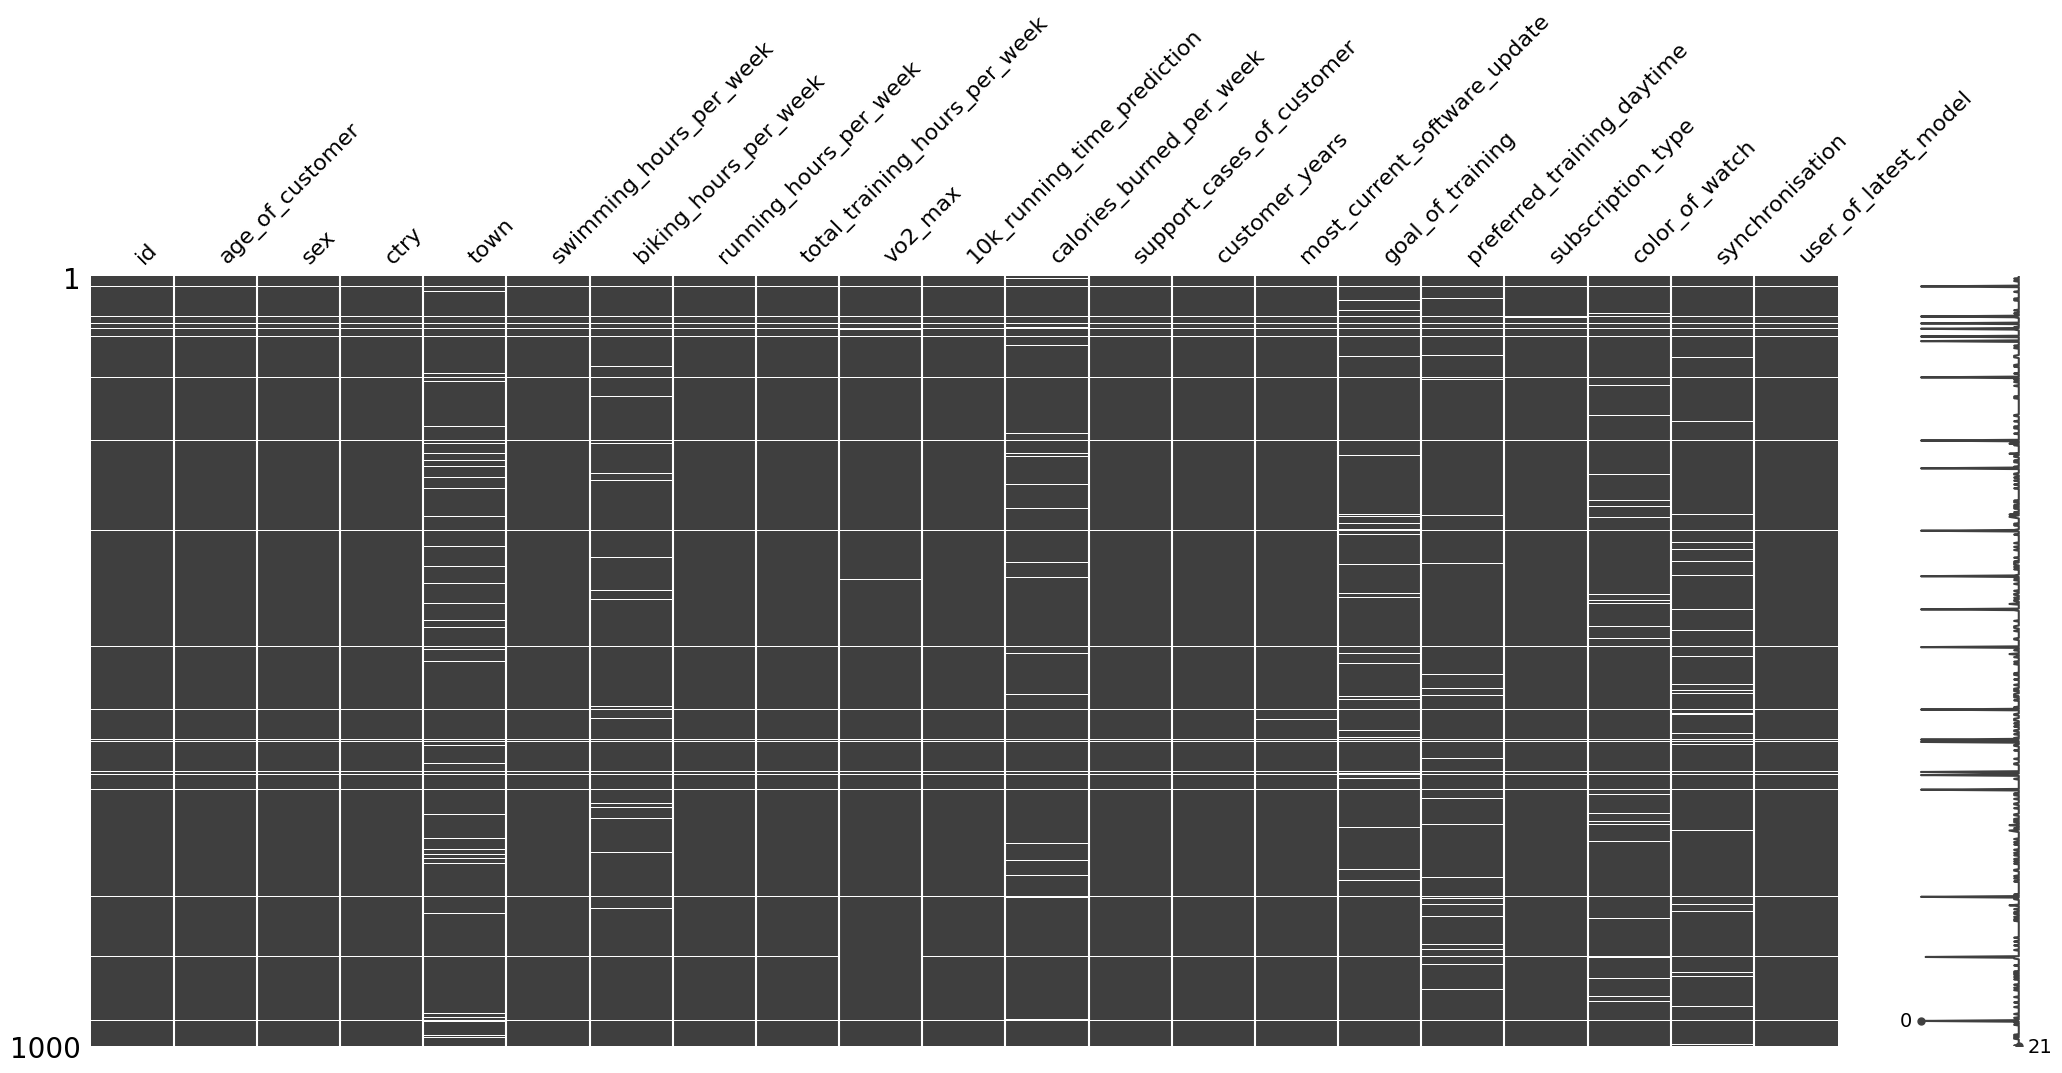

In [427]:
msno.matrix(df)

### Missing Value Handling - Listwise Deletion

In [428]:
#Show rows in which label is NaN
df[df['user_of_latest_model'].isnull()]

,id,age_of_customer,sex,ctry,town,swimming_hours_per_week,biking_hours_per_week,running_hours_per_week,total_training_hours_per_week,vo2_max,...,calories_burned_per_week,support_cases_of_customer,customer_years,most_current_software_update,goal_of_training,preferred_training_daytime,subscription_type,color_of_watch,synchronisation,user_of_latest_model
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [429]:
#Drop all rows with missing values in the column 'user_of_latest_model'
df=df.drop(df[df['user_of_latest_model'].isnull()].index)


In [430]:
#show rows with more than two columns with missing values
df[df.isnull().sum(axis=1)>2]

,id,age_of_customer,sex,ctry,town,swimming_hours_per_week,biking_hours_per_week,running_hours_per_week,total_training_hours_per_week,vo2_max,...,calories_burned_per_week,support_cases_of_customer,customer_years,most_current_software_update,goal_of_training,preferred_training_daytime,subscription_type,color_of_watch,synchronisation,user_of_latest_model


<Axes: >

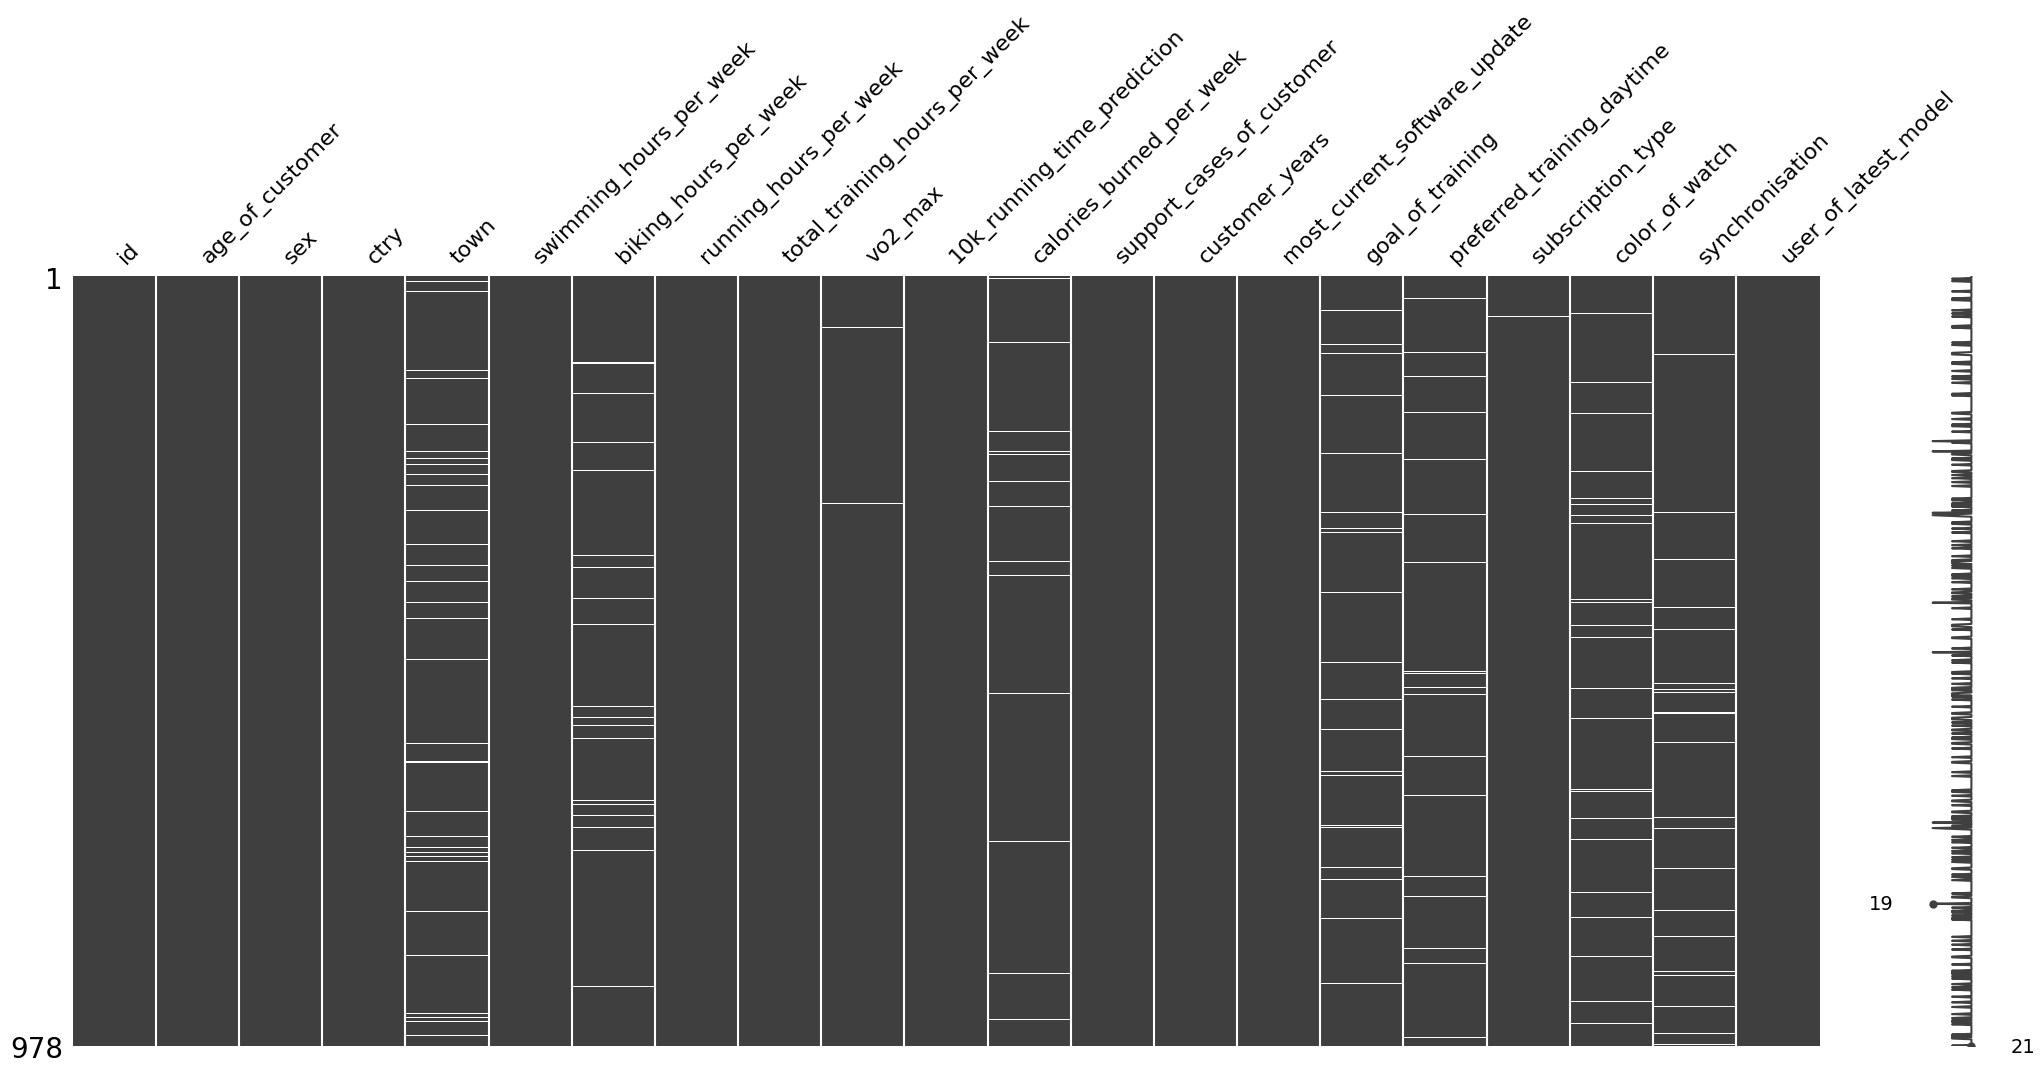

In [431]:
msno.matrix(df)

### Regression Imputation of numeric columns

In [432]:
# Append all categorical and numeric columns to different lists
categorical = df.select_dtypes(include=['object']).columns.to_list()
numeric=df.select_dtypes(include=['float64']).columns.tolist()


Outliers and empty values in the numeric colums are identified and imputed by linear regression imputation. Therefore the outliers are first identified with IQR method and replaced by empty values. In the next step all empty values are replaced by the median as initial imputation. In a iterative imputation process the former missing values in every column are replaced by the value predicted by the linear regression model fitted by all other numeric columns. This process is repeated 30 times.

In [433]:
#  Detection of outliers with IQR-method
def detect_outliers_iqr(df):
    df_outliers = df.copy()
    for col in df.select_dtypes(include=np.number):  # Nur numerische Spalten
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_outliers[col] = df[col].apply(lambda x: np.nan if x < lower_bound or x > upper_bound else x)
    return df_outliers


#  Replacement of outliers mit NaN
data_numeric_no_outliers = detect_outliers_iqr(df[numeric])

#  Iterative Imputation for numeric columns
imputer = IterativeImputer(max_iter=30, tol=1e-2, random_state=42, initial_strategy='median') #initial all missing values were replaced by median
data_numeric_imputed = pd.DataFrame(imputer.fit_transform(data_numeric_no_outliers), columns=df[numeric].columns) # creating a new dataframe with imputed values

data_numeric_imputed.index = df.index # adapt index of new dataframe to index of original dataframe
df_imputed_numeric = df.copy() # create a copy of the original dataframe
df_imputed_numeric[numeric] = data_numeric_imputed # replace numeric columns in original dataframe with imputed values

print(df_imputed_numeric[numeric].isnull().sum()) # check if all missing values in numeric columns were imputed

age_of_customer                  0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
most_current_software_update     0
user_of_latest_model             0
dtype: int64


### Imputation of categoric columns

In [434]:
df_imputed_numeric[categorical].isnull().sum()

id                             0
sex                            0
ctry                           0
town                          39
goal_of_training              28
preferred_training_daytime    24
subscription_type              1
color_of_watch                32
synchronisation               28
dtype: int64

Folgende Überlegungen zur Imputation der fehlenden Werte in den kategorischen Spalten:

 Keine Kategorie dominiert → Der Modus wäre ungeeignet.

 "Fehlend" hat keine Bedeutung → "Unknown" wäre nicht sinnvoll.

Die besten Methoden sind:

 Zufällige Imputation nach Häufigkeit (probabilistisch) – Bewahrt die ursprüngliche Verteilung.
 
 KNN-Imputation – Sucht ähnliche Muster, ist aber rechenintensiver.

Da die Rechenleistung bei 1000 Datensätzen keine große Rolle spielt, entscheid ich mich für die KNN Imputation



In [439]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

# Transform categorical columns to numerical columns
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df_encoded = encoder.fit_transform(df_imputed_numeric[categorical])

# KNN-Imputation mit k=5 (berücksichtigt 5 nächste Nachbarn)
knn_imputer = KNNImputer(n_neighbors=5)
df_imputed = knn_imputer.fit_transform(df_encoded)

# Werte zurück in Kategorien umwandeln
df_imputed_numeric[categorical] = encoder.inverse_transform(df_imputed)

In [440]:
df_imputed_numeric.isnull().sum()

id                               0
age_of_customer                  0
sex                              0
ctry                             0
town                             0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
most_current_software_update     0
goal_of_training                 0
preferred_training_daytime       0
subscription_type                0
color_of_watch                   0
synchronisation                  0
user_of_latest_model             0
dtype: int64